In [1]:
import os
import time
import yaml
import math
import pandas as pd
import numpy as np

In [2]:
from data.excel2pd import data_load
from data.preprocessing import data_preprocessing
from data.train_test_split import data2Window, X_Y2train_test, X_Y_from_data
from data.CustomDataset import CustomDataset

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더
from model.model import Transformer

import sys
sys.setrecursionlimit(4000)

In [4]:
# torch version, gpu 사용 여부, 이름 체크
print("torch version>>", torch.__version__)
print("GPU 사용 유무>>", torch.cuda.is_available())
if torch.cuda.is_available() :
    print("GPU 이름>> ", torch.cuda.get_device_name(0))
    device = "cuda:0" 
else :
    device = "cpu"
print(device)

torch version>> 1.13.1
GPU 사용 유무>> True
GPU 이름>>  NVIDIA GeForce RTX 2080
cuda:0


In [5]:
f = open("Settings.yaml", 'r')
setup = yaml.load(f, Loader=yaml.FullLoader)

data = data_load(11)
scaler, data = data_preprocessing(data, setup['data_options'])

X, Y = X_Y_from_data(data)

if setup['data_options']['CGM'] == 3:
    input_size = 1
else:
    input_size = 3

X_train, Y_train, X_test, Y_test = X_Y2train_test(X=X, Y=Y,
                                                  output_window=setup['output_window'],
                                                  input_size=input_size,
                                                  stride=setup['stride'])

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(51166, 6, 1) (51166, 6)
(309, 6) (309, 6)


In [6]:
dataset = CustomDataset(X_train, Y_train)
dataloader = DataLoader(dataset, batch_size = setup['batch'], shuffle=False)

In [7]:
model = Transformer(d_model=setup['batch'], nhead=10, nlayers=1, dropout=0.3).to(device)

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,186,177 trainable parameters


In [10]:
model.train()

Transformer(
  (positional_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=2048, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (linear2): Linear(in_features=2048, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.5, inplace=False)
    (dropout2): Dropout(p=0.5, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=12

In [11]:
from model.train import train

model, optimizer = train(device = device, model = model, 
                         dataloader = dataloader, 
                         learning_rate = setup['learning_rate'], 
                         epochs = setup['epoch'],
                         output_window = setup['output_window'])

100%|██████████| 150/150 [57:51<00:00, 23.15s/it, loss=34.52946] 


In [12]:
#model save
import os
from datetime import datetime
#from model.train import save_model

now = datetime.now()
save_path = "./result/"+now.strftime('%Y_%m_%d_%H_%M')
try:
    if not os.path.exists(save_path) : 
        os.mkdir(save_path)
except:
    print("Error : Failed to create the directory.")

#save_model(save_path, model, optimizer)

In [13]:
from model.predict import predict

prediction = predict(model, X_test, setup['output_window'], scaler, setup['data_options']['CGM'], device)

3


['2024-05-01 15:37:59.205528', 24.751273047191038, 24.88609679385682, 29.41637788404844, 29.522430883928784]


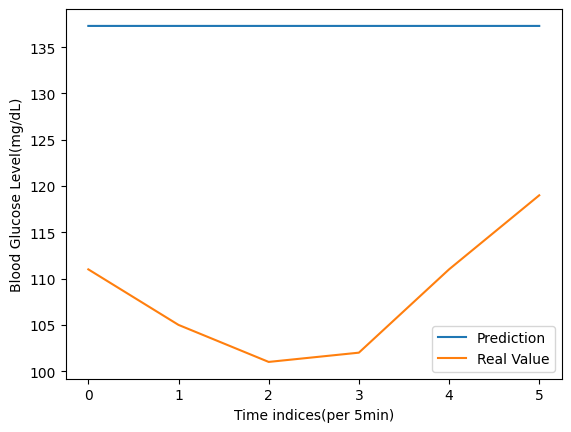

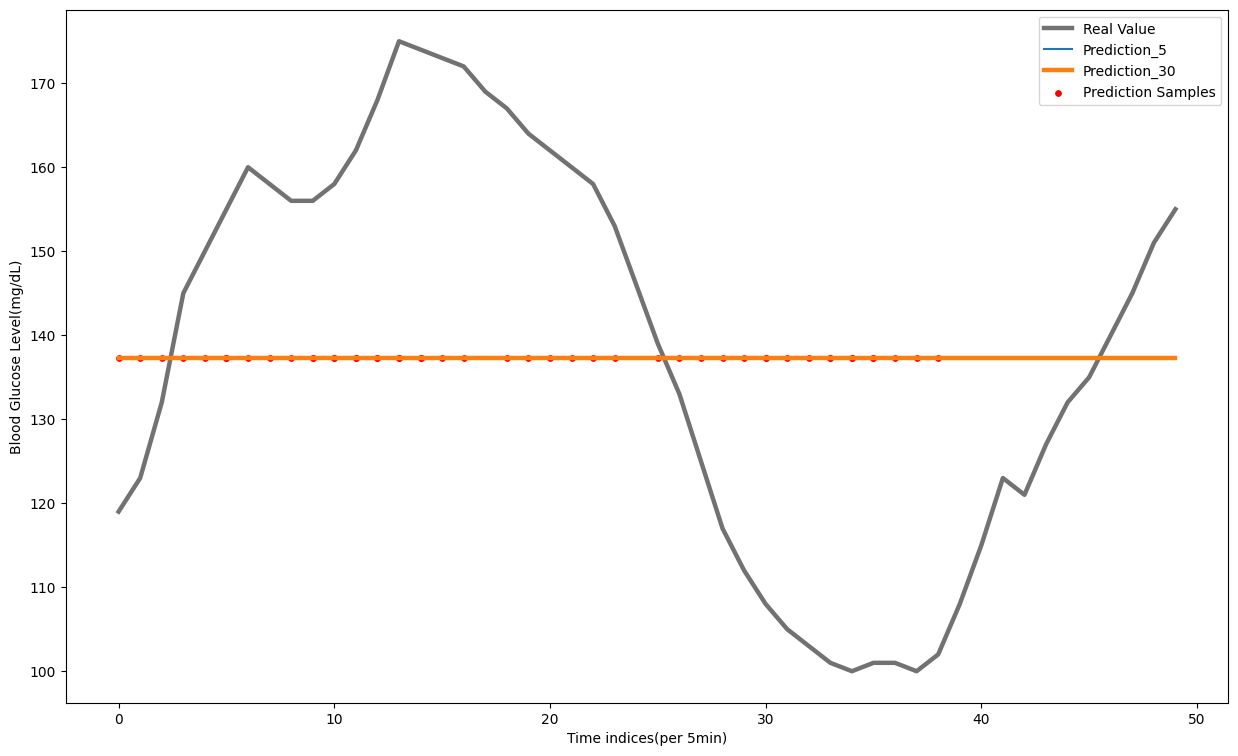

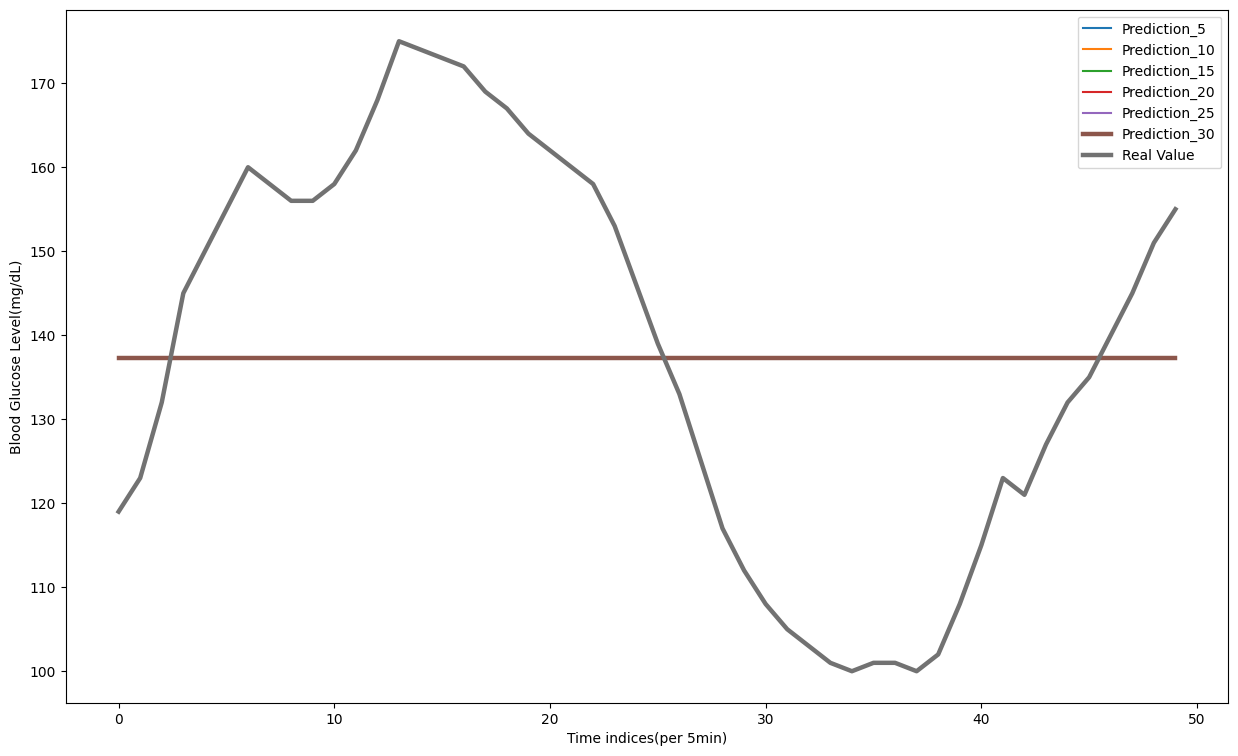

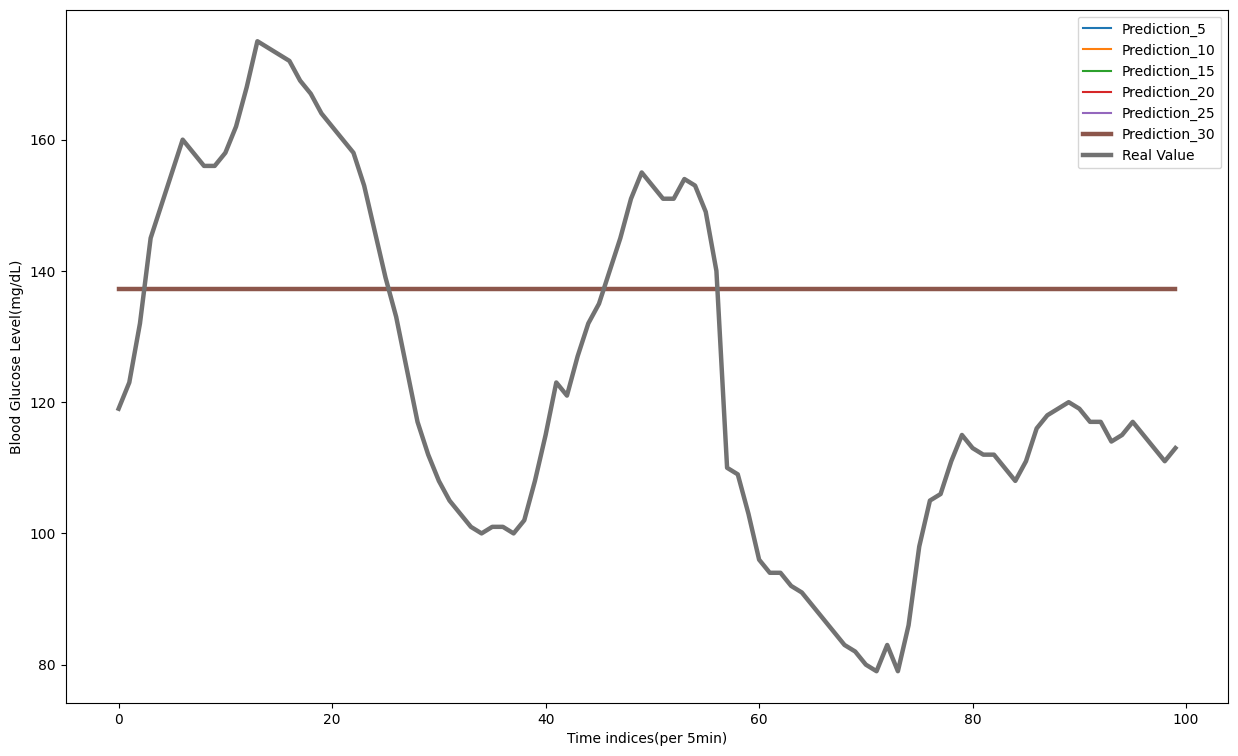

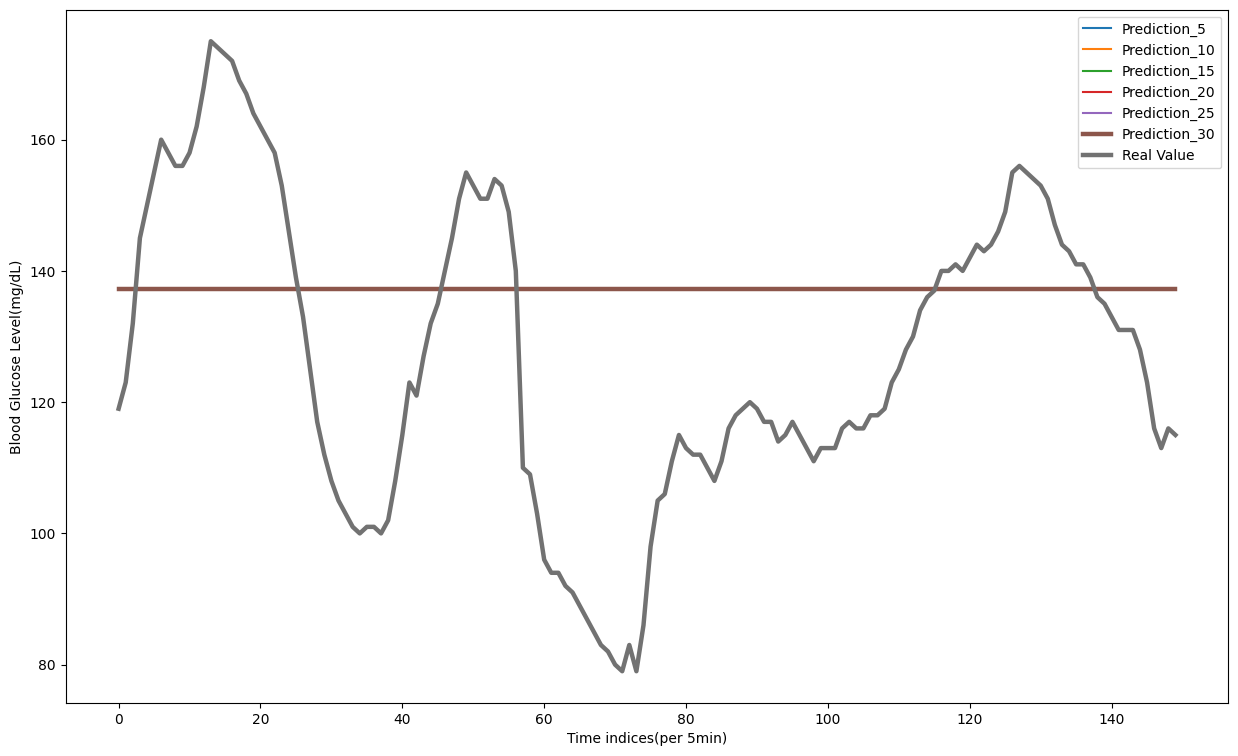

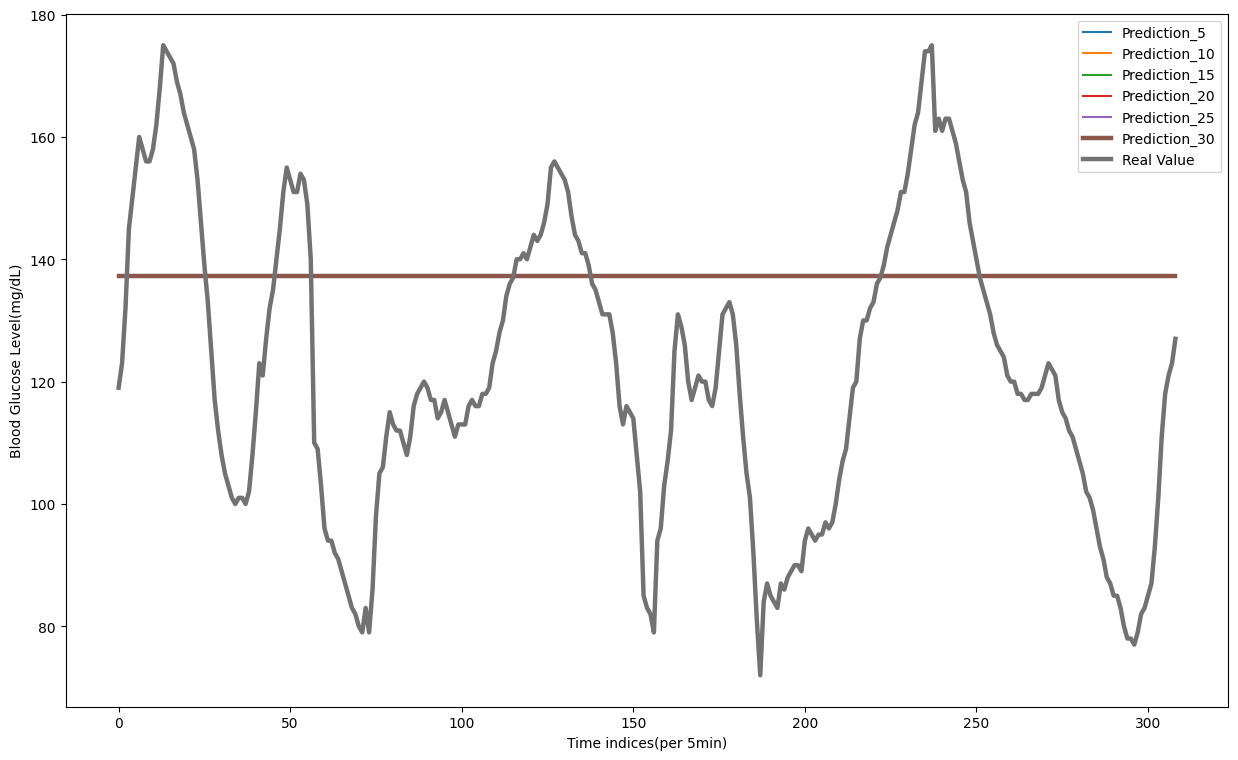

In [14]:
from model.result import result_jpg, save_yaml_and_error, save_numeric_result

result_jpg(prediction, Y_test, save_path)
save_yaml_and_error("./", save_path, now)
save_numeric_result(prediction, Y_test, now)